# ShuffleNet

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as K
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
# from tensorflow.keras import datasets, layers, models

from tensorflow.keras.models import Model

from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, ReLU, 
                                    MaxPooling2D, Add, GlobalAveragePooling2D, 
                                    Dense, DepthwiseConv2D, Lambda, Reshape, 
                                    Concatenate)

2024-11-07 00:05:42.692781: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 00:05:42.837118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730955942.902322     526 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730955942.919368     526 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 00:05:43.058276: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Preparation for trainning - Train Split

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'Dataset of Breast mammography images with Masses/Image After Data Augmentation, Image Size 224x224/',
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(224, 224),
    batch_size=32,
)

Found 7632 files belonging to 8 classes.
Using 6106 files for training.


I0000 00:00:1730955947.874078     526 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1756 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [4]:
classes_ = train_ds.class_names
len(classes_)

8

In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'Dataset of Breast mammography images with Masses/Image After Data Augmentation, Image Size 224x224/',
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(224, 224),
    batch_size=32,
)

Found 7632 files belonging to 8 classes.
Using 1526 files for validation.


In [6]:
def normalize(image, label):
  return tf.cast(image/255., tf.float32), label

train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)

train_ds, val_ds

(<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

# Preparation for trainning - Test Split

In [7]:
train_ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    'Dataset of Breast mammography images with Masses/Image Before Data Augmentation, Image Size 224x224/',
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(224, 224),
    batch_size=32,
)

Found 212 files belonging to 8 classes.
Using 170 files for training.


In [8]:
val_ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    'Dataset of Breast mammography images with Masses/Image Before Data Augmentation, Image Size 224x224/',
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(224, 224),
    batch_size=32,
)

Found 212 files belonging to 8 classes.
Using 42 files for validation.


In [9]:
def normalize(image, label):
  return tf.cast(image/255., tf.float32), label

train_ds_test = train_ds_test.map(normalize)
val_ds_test = val_ds_test.map(normalize)

train_ds_test, val_ds_test

(<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

# Training

In [10]:
def channel_shuffle(x, groups):
    height, width, in_channels = x.shape[1:]
    channels_per_group = in_channels // groups

    # Reshape into (batch, height, width, groups, channels_per_group)
    x = tf.reshape(x, [-1, height, width, groups, channels_per_group])
    x = tf.transpose(x, [0, 1, 2, 4, 3])  # Swap channels_per_group and groups
    x = tf.reshape(x, [-1, height, width, in_channels])  # Reshape back
    return x

def shuffle_unit(inputs, out_channels, stride, groups):
    in_channels = inputs.shape[-1]
    half_out_channels = out_channels // 2

    if stride == 2:
        # Split channels into two groups: one for the shortcut and one for the main path
        shortcut = DepthwiseConv2D(kernel_size=3, strides=stride, padding="same", use_bias=False)(inputs)
        shortcut = BatchNormalization()(shortcut)
        shortcut = Conv2D(half_out_channels, kernel_size=1, padding="same", use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)
        shortcut = ReLU()(shortcut)

        # Main path
        x = Conv2D(half_out_channels, kernel_size=1, padding="same", use_bias=False)(inputs)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        
        x = DepthwiseConv2D(kernel_size=3, strides=stride, padding="same", use_bias=False)(x)
        x = BatchNormalization()(x)
        
        x = Conv2D(half_out_channels, kernel_size=1, padding="same", use_bias=False)(x)
        x = BatchNormalization()(x)

        # Concatenate shortcut and main path
        x = Concatenate()([shortcut, x])
    else:
        # Main path with no downsampling
        shortcut = inputs
        x = Conv2D(half_out_channels, kernel_size=1, padding="same", use_bias=False)(inputs)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        
        x = DepthwiseConv2D(kernel_size=3, strides=stride, padding="same", use_bias=False)(x)
        x = BatchNormalization()(x)
        
        x = Conv2D(half_out_channels, kernel_size=1, padding="same", use_bias=False)(x)
        x = BatchNormalization()(x)
        
        # Concatenate shortcut and main path
        x = Concatenate()([shortcut, x])
    
    # Apply channel shuffle
    x = Lambda(channel_shuffle, arguments={'groups': groups})(x)
    
    return x

def build_shufflenet(input_shape=(224, 224, 3), num_classes=1000, groups=3):
    inputs = Input(shape=input_shape)
    x = Conv2D(24, kernel_size=3, strides=2, padding="same", use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = MaxPooling2D(pool_size=3, strides=2, padding="same")(x)

    # Stacking ShuffleNet units
    for out_channels, num_units, stride in [(240, 4, 2), (480, 8, 2), (960, 4, 2)]:
        for i in range(num_units):
            x = shuffle_unit(x, out_channels, stride if i == 0 else 1, groups)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    return model


model = build_shufflenet(input_shape=(224, 224, 3), num_classes=8, groups=3)


In [11]:
model.compile(optimizer='adam',
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

In [12]:
epochs = 30
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/30


I0000 00:00:1730955962.624244     621 service.cc:148] XLA service 0x7ff068002960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730955962.624858     621 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-11-07 00:06:03.110434: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730955964.479915     621 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-07 00:06:16.425250: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng34{k2=2,k4=0,k5=0,k6=0,k7=0,k19=0} for conv (f32[32,2160,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,2160,16,16]{3,2,1,0}, f32[2160,1,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, feature_group_count=2160, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config"

191/191 ━━━━━━━━━━━━━━━━━━━━ 103s 318ms/step - accuracy: 0.3423 - loss: 1.7836 - val_accuracy: 0.3028 - val_loss: 1.9502
Epoch 2/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 120ms/step - accuracy: 0.5206 - loss: 1.2423 - val_accuracy: 0.0754 - val_loss: 1.9734
Epoch 3/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 124ms/step - accuracy: 0.6354 - loss: 0.9433 - val_accuracy: 0.2366 - val_loss: 2.5905
Epoch 4/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 125ms/step - accuracy: 0.7707 - loss: 0.6348 - val_accuracy: 0.5360 - val_loss: 2.8782
Epoch 5/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 124ms/step - accuracy: 0.8727 - loss: 0.3586 - val_accuracy: 0.5872 - val_loss: 1.9766
Epoch 6/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 120ms/step - accuracy: 0.9058 - loss: 0.2598 - val_accuracy: 0.3119 - val_loss: 7.3088
Epoch 7/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - accuracy: 0.9305 - loss: 0.1916 - val_accuracy: 0.8008 - val_loss: 0.7280
Epoch 8/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step - accuracy: 0.9516 - loss: 0.1315 - va

# Evaluating

In [14]:
history.history

{'accuracy': [0.40795937180519104,
  0.5533900856971741,
  0.6794955730438232,
  0.7941369414329529,
  0.8748771548271179,
  0.9228627681732178,
  0.9344906806945801,
  0.9580740332603455,
  0.9659351706504822,
  0.9616770148277283,
  0.9690468311309814,
  0.9780543446540833,
  0.9721585512161255,
  0.9770717620849609,
  0.9760891199111938,
  0.9706845879554749,
  0.9739600419998169,
  0.980347216129303,
  0.9906648993492126,
  0.9842777848243713,
  0.9852604269981384,
  0.9765804409980774,
  0.978218138217926,
  0.9849328398704529,
  0.9960694313049316,
  0.9965607523918152,
  0.972649872303009,
  0.980347216129303,
  0.9752702116966248,
  0.9895185232162476],
 'loss': [1.5608761310577393,
  1.1634325981140137,
  0.833355188369751,
  0.5595288276672363,
  0.348686158657074,
  0.2138751596212387,
  0.1853819042444229,
  0.12153153866529465,
  0.09594769775867462,
  0.1098640188574791,
  0.09346597641706467,
  0.06362798810005188,
  0.0793653279542923,
  0.06897126138210297,
  0.0643399

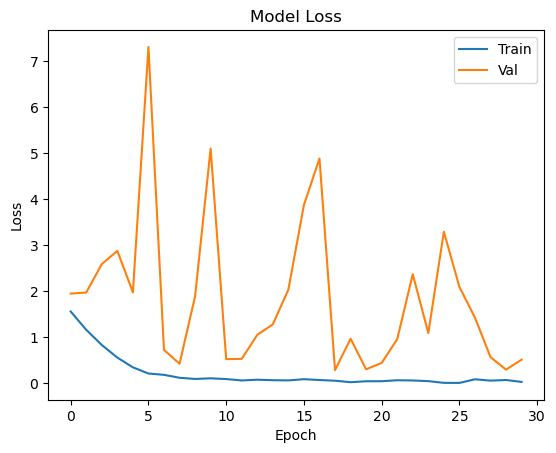

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

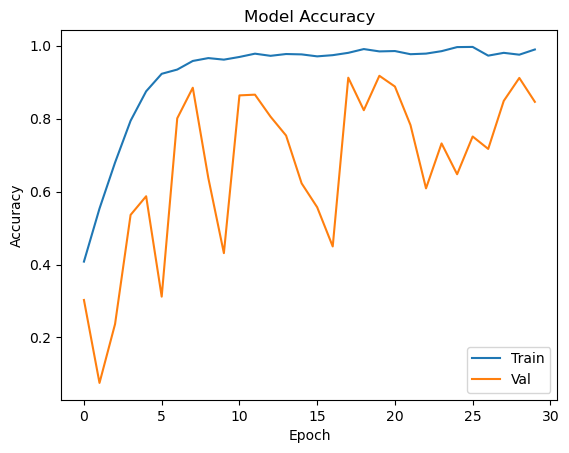

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [17]:
test_loss, test_acc = model.evaluate(val_ds, verbose=2)

48/48 - 2s - 33ms/step - accuracy: 0.8460 - loss: 0.5146


In [18]:
print(test_acc)

0.8460026383399963


In [19]:
predictions = model.predict(train_ds_test)
val_pred = np.argmax(predictions, axis=1)

4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step 

2024-11-07 00:19:27.059669: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng34{k2=2,k4=0,k5=0,k6=0,k7=0,k19=0} for conv (f32[10,2160,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,2160,15,15]{3,2,1,0}, f32[2160,1,3,3]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, feature_group_count=2160, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-11-07 00:19:27.251525: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.192003662s
Trying algorithm eng34{k2=2,k4=0,k5=0,k6=0,k7=0,k19=0} for conv (f32[10,2160,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,2160,15,15]{3,2,1,0}, f32[2160,1,3,3]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, feature_group_count=2

6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step


In [20]:
y_true = []
y_pred = []
for images, labels in val_ds_test:
  # Make predictions on the batch
  batch_pred = model.predict(images)
  y_pred.extend(list(batch_pred.argmax(axis=1)))  # Predicted labels
  y_true.extend(list(labels.numpy()))  # True labels from the batch

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


2024-11-07 00:19:34.484777: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


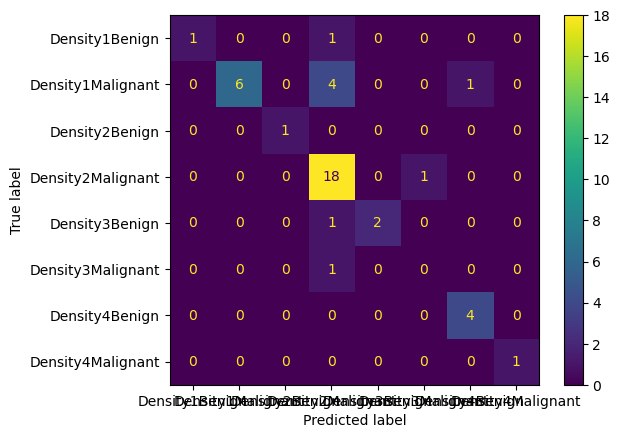

In [21]:
disp = ConfusionMatrixDisplay(cm, display_labels=classes_,)
disp.plot()

In [22]:
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       1.00      0.55      0.71        11
           2       1.00      1.00      1.00         1
           3       0.72      0.95      0.82        19
           4       1.00      0.67      0.80         3
           5       0.00      0.00      0.00         1
           6       0.80      1.00      0.89         4
           7       1.00      1.00      1.00         1

    accuracy                           0.79        42
   macro avg       0.81      0.71      0.73        42
weighted avg       0.83      0.79      0.78        42



# Save

In [23]:
# model.save('models/breast_cancer_classification-shufflenet.h5')